## results of splitting dataset so target only ever appears on one side in training set but appears on both sides in test set

In [1]:
import json
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import searchnets
from searchnets import plot
from searchnets.utils.metrics import compute_d_prime

In [2]:
HERE = Path('/home/bart/Documents/repos/L2M/visual-search-nets/docs/notebooks/supp-info')

In [3]:
results_dir = HERE.joinpath('../../../data/expt_13_gpu/results/')
data_prep_dir = HERE.joinpath('../../../data/expt_13_gpu/data_prepd_for_nets/')
vis_search_stims_dir = HERE.joinpath('../../../data/visual_search_stimuli/')

In [4]:
test_csv_path = '../../../data/expt_13/csv/alexnet_train_test_target_split_data.csv'

In [5]:
GRID_SHAPE = (5, 5)
TRAIN_MASK = np.zeros(GRID_SHAPE).astype(np.int32)
TRAIN_MASK[:, :3] = 1

In [6]:
HEADER = ['net_name',
          'train_type',
          'net_number',
          'stimulus',
          'set_size',
          'target_condition',
          'accuracy',
          'hit_rate',
          'false_alarm_rate',
          'd_prime',
          ]

def split_results_df(results_dir,
                     data_prepd_dir,
                     vis_search_stims_dir,
                     test_csv_path=test_csv_path,
                     train_mask=TRAIN_MASK,
                     nets=('alexnet',),
                     train_types=('train_test_target_split', 'train_less_shards'),
                     stims=('2_v_5', 'RVvGV', 'RVvRHGV'),
                     target_condition=('present_all', 'present_train_only', 'present_test_only' 'absent', 'both')):
    """create dataframe from results where dataset was split so target appears in locations in test set that never appeared in training set"""
    rows = []
    for train_type in train_types:
        for net in nets:
            for stim in stims:
                data_gz_path = data_prepd_dir.joinpath(f'{net}_{train_type}_{stim}_data.gz')
                data_dict = joblib.load(data_gz_path)
                x_test = data_dict['x_test']
                y_test = data_dict['y_test']
                set_size_vec_test = data_dict['set_size_vec_test']
                set_sizes = data_dict['set_sizes_by_stim_type'][stim]

                json_fname = vis_search_stims_dir.joinpath(f'{net}_train_{stim}/{net}_train_{stim}.json')
                if json_fname.exists():
                        with open(json_fname) as fp:
                            stim_meta_dict = json.load(fp)

                        stim_meta_list = []
                        stim_meta_dict = stim_meta_dict[stim]
                        for set_size, stim_meta_this_set_size in stim_meta_dict.items():
                            # *** only using present because we only care about splitting target present condition up ***
                            stim_meta_list.extend(stim_meta_this_set_size['present'])

                        fname_grid_map = {}
                        for meta_d in stim_meta_list:
                            stim_fname_meta = Path(meta_d['filename']).name
                            char_grid = np.asarray(meta_d['grid_as_char'])
                            fname_grid_map[stim_fname_meta] = char_grid

                # figure out from character grid if target appears within area of mask used to make training data set
                # i.e. if the trained network has seen the target in this location before
                target_in_mask = []
                for fname in x_test:
                    fname = Path(fname).name
                    if 'absent' in fname:
                        # -1 means "not a target present stimulus"
                        target_in_mask.append(-1)
                    elif 'present' in fname:
                        char_grid = fname_grid_map[fname]
                        if np.any(np.logical_and(char_grid == 't', train_mask)):
                            # 1 means, yes, target appears within mask, 
                            # i.e., target appeared here in training set -- network has seen this location
                            target_in_mask.append(1)
                        else:
                            # 0 means, no, target did not appear here in training set -- network has not seen this location
                            target_in_mask.append(0)

                target_in_mask = np.asarray(target_in_mask)

                results_gz_path = list(results_dir.joinpath(f'{net}_{train_type}_{stim}').glob(f'*test*.gz'))
                if len(results_gz_path) == 1:
                    results_gz_path = results_gz_path[0]
                else:
                    raise ValueError(
                        f'did not find only a single results_gz_path, instead found: {results_gz_path}'
                    )
                
                results_dict = joblib.load(results_gz_path)
                ppm = results_dict['predictions_per_model_dict']
                num_nets = len(ppm.keys())
                for net_num in range(num_nets):
                    key = [key for key in ppm.keys() if f'net_number_{net_num}' in key][0]
                    y_pred = ppm[key]
                    for target_cond in target_condition:
                        for set_size in set_sizes:
                            if target_cond == 'present_all':
                                inds_this_cond = np.where(
                                    np.logical_and(y_test == 1, set_size_vec_test == set_size))
                            elif target_cond == 'present_train_only':
                                inds_this_cond = np.where(
                                    np.logical_and(target_in_mask == 1, set_size_vec_test == set_size))
                            elif target_cond == 'present_test_only':
                                inds_this_cond = np.where(
                                    np.logical_and(target_in_mask == 0, set_size_vec_test == set_size))                                
                            elif target_cond == 'absent':
                                inds_this_cond = np.where(
                                    np.logical_and(y_test == 0, set_size_vec_test == set_size))
                            elif target_cond == 'both':
                                inds_this_cond = np.where(set_size_vec_test == set_size)[0]
                            acc = np.sum(y_pred[inds_this_cond] == y_test[inds_this_cond])
                            acc = acc / y_test[inds_this_cond].shape[0]

                            if target_cond == 'both':
                                hit_rate, false_alarm_rate, d_prime = compute_d_prime(
                                    y_pred[inds_this_cond], y_test[inds_this_cond]
                                )
                            else:
                                hit_rate, false_alarm_rate, d_prime = None, None, None
                            row = [net, train_type, net_num, stim, set_size, target_cond,
                                   acc, hit_rate, false_alarm_rate, d_prime]
                            rows.append(row)

    df = pd.DataFrame.from_records(rows, columns=HEADER)
    return df

In [7]:
df = split_results_df(results_dir,
                      data_prep_dir,
                      vis_search_stims_dir,
                      test_csv_path=test_csv_path,
                      nets=('alexnet',),
                      train_types=('train_test_target_split', 'train_less_shards'),
                      stims=('2_v_5', 'RVvGV', 'RVvRHGV'),
                      target_condition=('present_all', 'present_train_only', 'present_test_only', 'absent', 'both'))

/home/bart/Documents/repos/L2M/visual-search-nets/src/searchnets/utils/metrics.py:15: RuntimeWarning: invalid value encountered in long_scalars
  hit_rate = hits / (hits + misses)
/home/bart/Documents/repos/L2M/visual-search-nets/src/searchnets/utils/metrics.py:24: RuntimeWarning: divide by zero encountered in true_divide
  half_hit = 0.5 / (hits + misses)


In [12]:
def metric_v_set_size_df(df, net_name, train_type, stimulus, metric, conditions,
                         ax=None, title=None, save_as=None, figsize=(10, 5),
                         set_xlabel=False, set_ylabel=False, set_ylim=True,
                         ylim=(0, 1.1), plot_mean=True, add_legend=False):
    """plot accuracy as a function of visual search task set size
    for models trained on a single task or dataset

    Accepts a Pandas dataframe and column names that determine what to plot.
    Dataframe is produces by searchstims.utils.general.results_csv function.

    Parameters
    ----------
    df : pandas.Dataframe
        path to results.gz file saved after measuring accuracy of trained networks
        on test set of visual search stimuli
    net_name : str
        name of neural net architecture. Must be a value in the 'net_name' column
        of df.
    train_type : str
        method used for training. Must be a value in the 'train_type' column of df.
    stimulus : str
        type of visual search stimulus, e.g. 'RVvGV', '2_v_5'. Must be a value in
        the 'stimulus' column of df.
    metric : str
        metric to plot. One of {'acc', 'd_prime'}.
    conditions : list, str
        conditions to plot. One of {'present', 'absent', 'both'}. Corresponds to
        'target_condition' column in df.

    Other Parameters
    ----------------
    ax : matplotlib.Axis
        axis on which to plot figure. Default is None, in which case a new figure with
        a single axis is created for the plot.
    title : str
        string to use as title of figure. Default is None.
    save_as : str
        path to directory where figure should be saved. Default is None, in which
        case figure is not saved.
    figsize : tuple
        (width, height) in inches. Default is (10, 5). Only used if ax is None and a new
        figure is created.
    set_xlabel : bool
        if True, set the value of xlabel to "set size". Default is False.
    set_ylabel : bool
        if True, set the value of ylabel to metric. Default is False.
    set_ylim : bool
        if True, set the y-axis limits to the value of ylim.
    ylim : tuple
        with two elements, limits for y-axis. Default is (0, 1.1).
    plot_mean : bool
        if True, find mean accuracy and plot as a separate solid line. Default is True.
    add_legend : bool
        if True, add legend to axis. Default is False.

    Returns
    -------
    None
    """
    if ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(figsize)

    df = df[(df['net_name'] == net_name)
            & (df['train_type'] == train_type) 
            & (df['stimulus'] == stimulus)]

    if not all(
        [df['target_condition'].isin([targ_cond]).any() for targ_cond in conditions]
    ):
        raise ValueError(f'not all target conditions specified were found in dataframe.'
                         f'Target conditions specified were: {conditions}')

    
    net_colors = []
    mn_colors = []
    for targ_cond in conditions:
        if 'present' in targ_cond:
            net_colors.append('violet')
            if plot_mean:
                mn_colors.append('magenta')
            else:
                mn_colors.append(None)
        elif 'absent' in targ_cond:
            net_colors.append('lightgreen')
            if plot_mean:
                mn_colors.append('lawngreen')
            else:
                mn_colors.append(None)
        elif 'both' in targ_cond:
            net_colors.append('darkgrey')
            if plot_mean:
                mn_colors.append('black')
            else:
                mn_colors.append(None)
    
    handles = []
    labels = []
    
    set_sizes = None  # because we verify set sizes is the same across conditions
    net_nums = df['net_number'].unique()
    # get metric across set sizes for each training replicate
    # we end up with a list of vectors we can pass to ax.plot,
    # so that the 'line' for each training replicate gets plotted
    for targ_cond, net_color, mn_color in zip(conditions, net_colors, mn_colors):
        metric_vals = []
        for net_num in net_nums:
            metric_vals.append(
                df[(df['net_number'] == net_num)
                  & (df['target_condition'] == targ_cond)][metric].values
            )

            curr_set_size = df[(df['net_number'] == net_num) 
                               & (df['target_condition'] == targ_cond)]['set_size'].values
            if set_sizes is None:
                set_sizes = curr_set_size
            else:
                if not np.array_equal(set_sizes, curr_set_size):
                    raise ValueError(
                        f'set size for net number {net_num}, '
                        f'target condition {targ_cond},  did not match others'
                    )

        for arr_metric in metric_vals:
            ax.plot(set_sizes, arr_metric, color=net_color, linewidth=2,
                    linestyle='--', marker='o', zorder=1, alpha=0.85, label=None)

        if plot_mean:
            mn_metric = np.asarray(metric_vals).mean(axis=0)
            mn_metric_label = f'mean {metric},\n{targ_cond}'
            labels.append(mn_metric_label)
            mn_metric_line, = ax.plot(set_sizes, mn_metric,
                                              color=mn_color, linewidth=4,
                                              zorder=0,
                                              label=mn_metric_label)
            handles.append(mn_metric_line)

    ax.set_xticks(set_sizes)

    if title:
        ax.set_title(title)
    if set_xlabel:
        ax.set_xlabel('set size')
    if set_ylabel:
        ax.set_ylabel(metric)
    if set_ylim:
        ax.set_ylim(ylim)

    if add_legend:
        ax.legend(handles=handles,
                  labels=labels,
                  loc='lower left')

    if save_as:
        plt.savefig(save_as)

In [13]:
def one_net_three_stims(df, net_name, train_type, conditions=['present', 'absent'], figsize=(15, 5), ylim=(0.0, 1.05), add_legend=False, save_as=None):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=figsize)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    for col, (stim_name, stim_abbrev) in enumerate(zip(
        ['feature', 'conjunction', 'spatial configuration'],
        ['RVvGV', 'RVvRHGV', '2_v_5'])):
        if add_legend:
            if col == 0:
                add_legend_this_plot=True
            else:
                add_legend_this_plot=False
        else:
            add_legend_this_plot=False
        metric_v_set_size_df(df, net_name, train_type=train_type, stimulus=stim_abbrev, metric='accuracy', conditions=conditions,
                                                    ylim=ylim, ax=ax[col], add_legend=add_legend_this_plot)

    if save_as:
        plt.savefig(save_as)

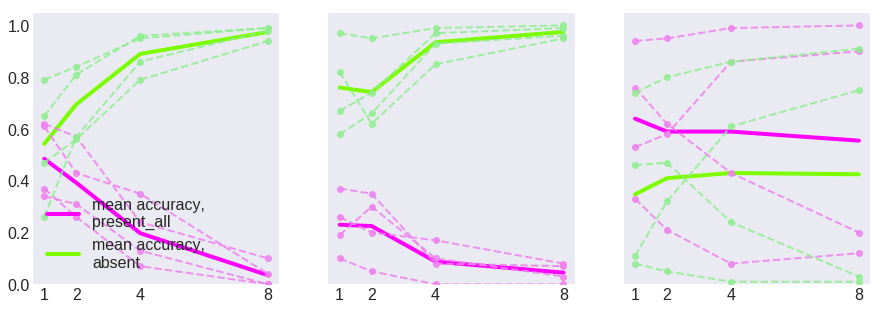

In [19]:
one_net_three_stims(df, 'alexnet', 'train_test_target_split', conditions=['present_all', 'absent'], add_legend=True)

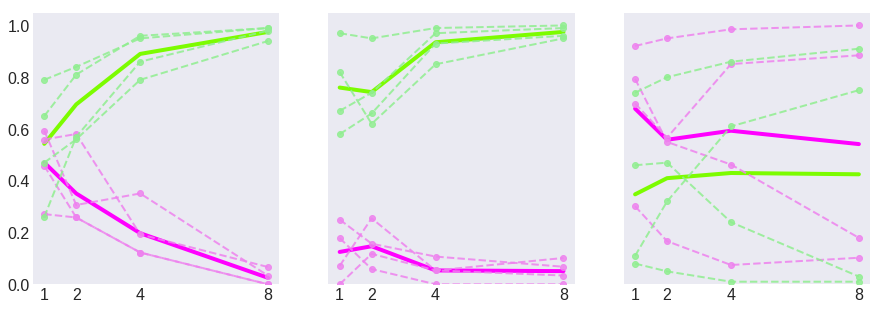

In [17]:
one_net_three_stims(df, 'alexnet', 'train_test_target_split', conditions=['present_train_only', 'absent'])

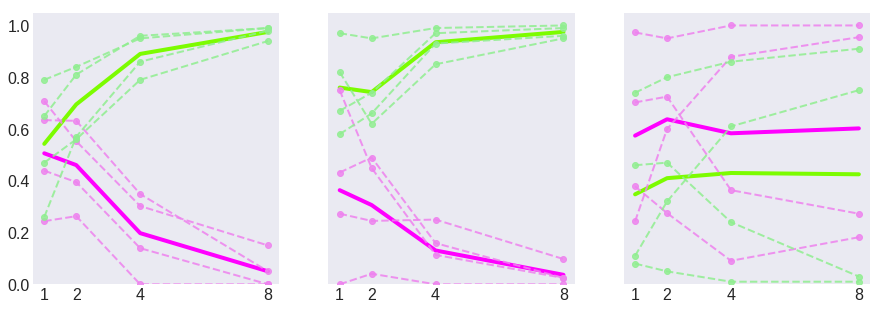

In [18]:
one_net_three_stims(df, 'alexnet', 'train_test_target_split', conditions=['present_test_only', 'absent'])

In [ ]:
def stat_diff(df, train_type, stimulus, target_condition, stat='accuracy'):
    df_to_use = df[
        (df['train_type'] == train_type) &
        (df['stimulus'] == stimulus) &
        (df['target_condition'] == target_condition)
    ]
    num_nets = df_to_use['net_number'].unique()
    set_sizes = df_to_use['set_size'].unique()
    min_set_size = set_sizes[0]
    max_set_size = set_sizes[-1]
    diffs = []
    for net_num in num_nets:
        min_stat = df_to_use[
            (df_to_use['net_number'] == net_num) &
            (df_to_use['set_size'] == min_set_size)][stat].values
        max_stat = df_to_use[
            (df_to_use['net_number'] == net_num) &
            (df_to_use['set_size'] == max_set_size)][stat].values
        diff = min_stat - max_stat
        diffs.append(diff)
    return diffs

In [ ]:
d = stat_diff(atft_df, 'finetune', '2_v_5', 'both')

In [ ]:
d

In [ ]:
d = stat_diff(atft_df, 'finetune', 'RVvGV', 'both')

In [ ]:
d
